In [1]:
import pandas as pd
from scipy.io import arff
import numpy as np
from scipy import stats
import tensorflow as tf

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef

from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import time
from tensorflow.keras.utils import to_categorical

import erlc as e
import dataPipeline as dp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataPipeline = dp.DataPipeline()
erlc = e.ERLC()

In [3]:
data = dataPipeline.loadData(num_sets = 15)
data.head()

Loading dataset #1
Loading dataset #2
Loading dataset #3
Loading dataset #4
Loading dataset #5
Loading dataset #6
Loading dataset #7
Loading dataset #8
Loading dataset #9
Loading dataset #10
Loading dataset #11
Loading dataset #12
Loading dataset #13
Loading dataset #14
Loading dataset #15
Finished Loading. Final Size = (78377, 129)


,R1-PA1:VH,R1-PM1:V,R1-PA2:VH,R1-PM2:V,R1-PA3:VH,R1-PM3:V,R1-PA4:IH,R1-PM4:I,R1-PA5:IH,R1-PM5:I,...,control_panel_log4,relay1_log,relay2_log,relay3_log,relay4_log,snort_log1,snort_log2,snort_log3,snort_log4,marker
0,70.399324,127673.0908,-49.572308,127648.0176,-169.578319,127723.2374,65.689611,605.91099,-57.003571,626.78553,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'41'
1,73.688102,130280.7109,-46.300719,130255.6377,-166.278082,130355.9307,71.831719,483.59351,-50.947407,500.98896,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'41'
2,73.733939,130305.7842,-46.254883,130280.7109,-166.232245,130381.0040,71.808800,483.59351,-50.913030,500.98896,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'41'
3,74.083443,130581.5902,-45.899649,130556.5169,-165.882741,130656.8100,72.152575,482.86107,-50.437475,499.15786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'41'
4,74.553268,131083.0556,-45.424094,131057.9823,-165.424375,131158.2754,72.118198,484.50906,-50.013486,497.69298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'41'


In [4]:
X, y = dataPipeline.dataProc(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
erlc.getLocalizationStats(X_train, y_train)

In [6]:
p_diff = erlc.getAveragePDforEachAttack(X_test, y_test)

Iteration i = 1
p_diff_temp shape = (116, 336)
p_diff_avg shape = (116,)
Iteration i = 2
p_diff_temp shape = (116, 381)
p_diff_avg shape = (116,)
Iteration i = 3
p_diff_temp shape = (116, 391)
p_diff_avg shape = (116,)
Iteration i = 4
p_diff_temp shape = (116, 591)
p_diff_avg shape = (116,)
Iteration i = 5
p_diff_temp shape = (116, 622)
p_diff_avg shape = (116,)
Iteration i = 6
p_diff_temp shape = (116, 675)
p_diff_avg shape = (116,)
Iteration i = 7
p_diff_temp shape = (116, 273)
p_diff_avg shape = (116,)
Iteration i = 8
p_diff_temp shape = (116, 232)
p_diff_avg shape = (116,)
Iteration i = 9
p_diff_temp shape = (116, 225)
p_diff_avg shape = (116,)
Iteration i = 10
p_diff_temp shape = (116, 331)
p_diff_avg shape = (116,)
Iteration i = 11
p_diff_temp shape = (116, 398)
p_diff_avg shape = (116,)
Iteration i = 12
p_diff_temp shape = (116, 407)
p_diff_avg shape = (116,)
Iteration i = 13
p_diff_temp shape = (116, 306)
p_diff_avg shape = (116,)
Iteration i = 14
p_diff_temp shape = (116, 339)

In [7]:
erlc.normal_means.shape

(116,)

In [8]:
p_diff.shape

(37, 116)

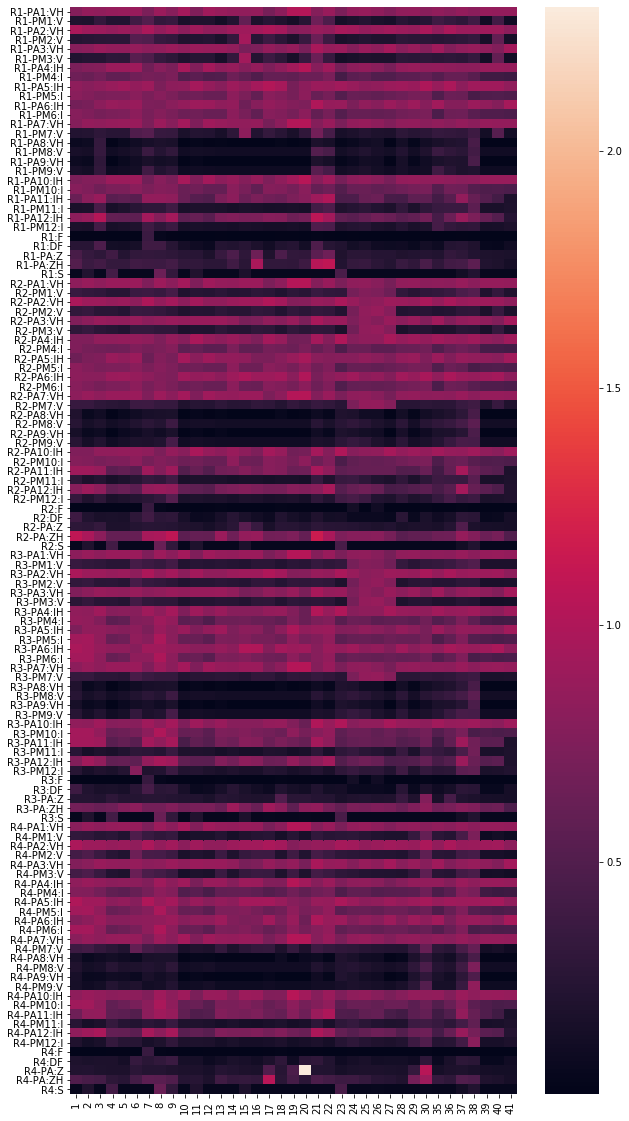

In [9]:
plt.figure(figsize=(10,20))
x_axis_labels = np.unique(y_test)
y_axis_labels = dataPipeline.getFeatureLabels(data)
sns.heatmap(np.transpose(p_diff), xticklabels=x_axis_labels, yticklabels=y_axis_labels)

In [10]:
maxes = []
for i in range(p_diff.shape[0]):
#     max_temp = np.where(p_diff[i] == np.max(p_diff[i]))
    temp = np.copy(p_diff[i])
#     temp[::-1].sort()

    max_temp = np.where(p_diff[i] > 0.8)

    print("Attack {}: ".format(i))
    print(max_temp)
    

Attack 0: 
(array([  2,   8,   9,  22,  29,  31,  38,  39,  41,  49,  56,  58,  60,
        64,  65,  67,  68,  69,  70,  76,  77,  78,  87,  89,  93,  95,
        96,  98,  99, 105, 106, 109]),)
Attack 1: 
(array([  0,   2,   4,  12,  20,  22,  29,  31,  33,  39,  41,  49,  51,
        56,  58,  60,  62,  64,  65,  66,  67,  68,  69,  70,  76,  77,
        78,  80,  87,  89,  91,  93,  95,  96,  97,  98,  99, 105, 106,
       107, 109]),)
Attack 2: 
(array([  0,   2,   4,   8,  10,  12,  20,  22,  29,  31,  33,  35,  41,
        47,  49,  51,  56,  58,  60,  62,  64,  66,  67,  68,  69,  70,
        76,  77,  78,  80,  87,  89,  91,  93,  95,  96,  97,  98,  99,
       105, 106, 107, 109]),)
Attack 3: 
(array([  0,   2,   4,   6,   8,  10,  12,  18,  29,  31,  33,  35,  37,
        39,  41,  47,  58,  60,  62,  66,  68,  70,  87,  89,  91,  93,
        95,  99, 105]),)
Attack 4: 
(array([  0,   2,   4,   6,   8,  10,  12,  18,  29,  31,  33,  35,  37,
        39,  41,  47,  58,  60,  

In [11]:
X[:,4].shape

(78377,)

In [12]:
y_axis_labels

Index(['R1-PA1:VH', 'R1-PM1:V', 'R1-PA2:VH', 'R1-PM2:V', 'R1-PA3:VH',
       'R1-PM3:V', 'R1-PA4:IH', 'R1-PM4:I', 'R1-PA5:IH', 'R1-PM5:I',
       ...
       'R4-PM10:I', 'R4-PA11:IH', 'R4-PM11:I', 'R4-PA12:IH', 'R4-PM12:I',
       'R4:F', 'R4:DF', 'R4-PA:Z', 'R4-PA:ZH', 'R4:S'],
      dtype='object', length=116)

In [13]:
erlc.normal_std

array([0.28058924, 0.05668093, 0.31015094, 0.03478923, 0.26965711,
       0.03509296, 0.27699541, 0.10837902, 0.3038023 , 0.11975944,
       0.26465069, 0.12162093, 0.28059412, 0.04009758, 0.03717537,
       0.05852926, 0.03555005, 0.05274125, 0.27701771, 0.122611  ,
       0.19022339, 0.0787669 , 0.2025796 , 0.06786183, 0.0096625 ,
       0.01136379, 0.00911385, 0.0391044 , 0.05102738, 0.28319504,
       0.11239045, 0.30809759, 0.08381818, 0.26746881, 0.07746891,
       0.27711056, 0.12196991, 0.26430356, 0.11964468, 0.30255332,
       0.12166427, 0.28328211, 0.08786981, 0.03727134, 0.08815538,
       0.03508809, 0.07061068, 0.27707397, 0.11978997, 0.20611591,
       0.08266663, 0.1950784 , 0.05696685, 0.0074365 , 0.01185596,
       0.00632473, 0.32684688, 0.05138557, 0.28318604, 0.05033671,
       0.30810927, 0.03757648, 0.26748325, 0.03713096, 0.27727718,
       0.01428204, 0.26465851, 0.01252354, 0.30196689, 0.01271807,
       0.28327763, 0.08814899, 0.03728101, 0.08795675, 0.03510